# Spaxel-by-Spaxel fitting

The best thing we can do is not just 

You go through each spaxel in the cube

Extract the spectrum for that spaxel

Fit a model to that 1D spectrum (e.g. emission lines, continuum, absorption)

Store the fitted parameters (e.g., flux, velocity, width) in a 2D map

This allows you to create maps of physical quantities like:

Emission line flux

Velocity fields

Velocity dispersion

Equivalent widths

Stellar population parameters

# Performing the background subtraction.

We start like before with importing the right libraries, and load the data

In [51]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23



PATH='/Users/jansen/My Drive/Astro/'


path = '/Users/jansen/JADES/GA_NIFS/IFS_data_v1/' 
file_name = '5001-GS-3.47-S_jw1216_o005_ff_px0.05_drizzle_ODfde98_3_VSC_MRC_MSA_m2ff_CTX1068.pmap_v1.8.2_g235h-f170lp_cgs_s3d.fits' # Full path to the file

Full_path = path + file_name

with pyfits.open(Full_path, memmap=False) as hdulist:

    Flux_cube = hdulist['SCI'].data *1e4 * 1e15
    Header = hdulist['SCI'].header

    n_channels = Header['NAXIS3'] # Extract the number pixels in the third axis (wavelength)
    obs_wave = Header['CRVAL3'] + (np.arange(n_channels) - (Header['CRPIX3'] - 1.0))*Header['CDELT3'] # Extract the wavelength grid


z = 3.471

plt.show()


## In QFitsView

In QFitsView we can create a background spectrum by creating a mask of most of pixels not occupied by the galaxy. Plese dont forget to use median spectrum rather than the sum. 

![Screenshot 2025-07-13 at 13.12.15.png](<attachment:Screenshot 2025-07-13 at 13.12.15.png>)


and we save it as a fits file called background.fits into some working folder.

We can now load it into python and show this file spectrum. 



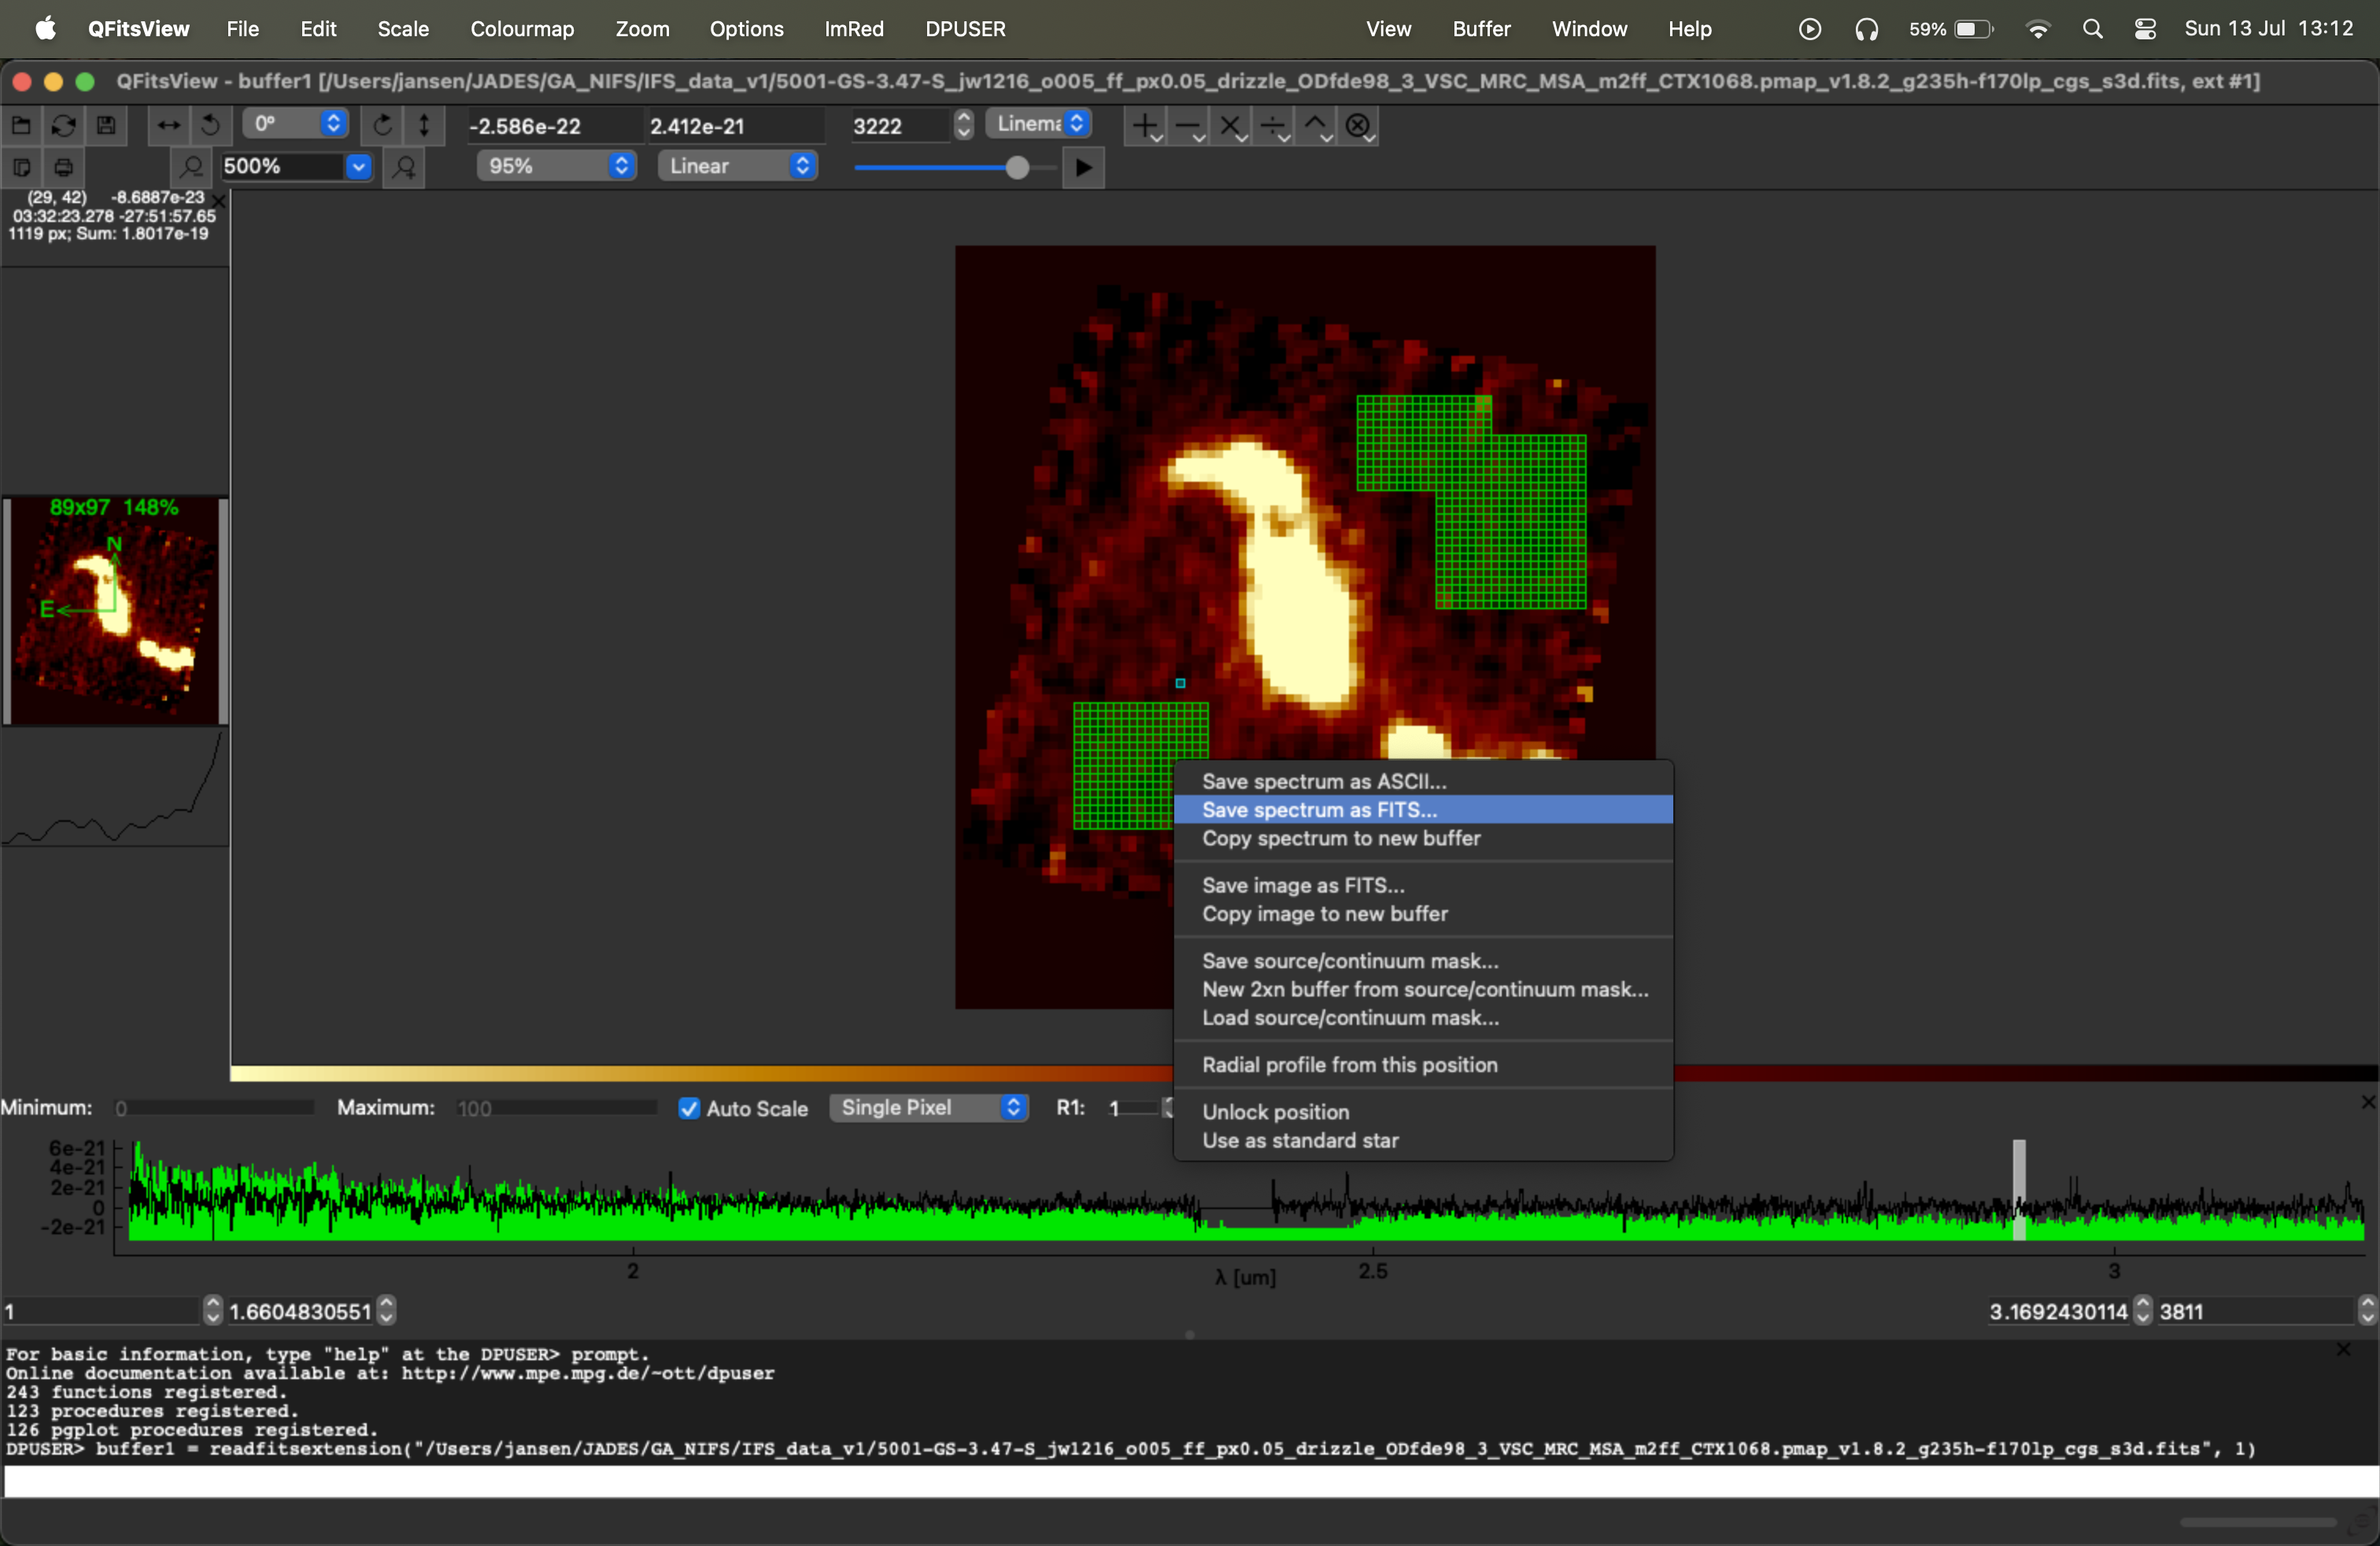

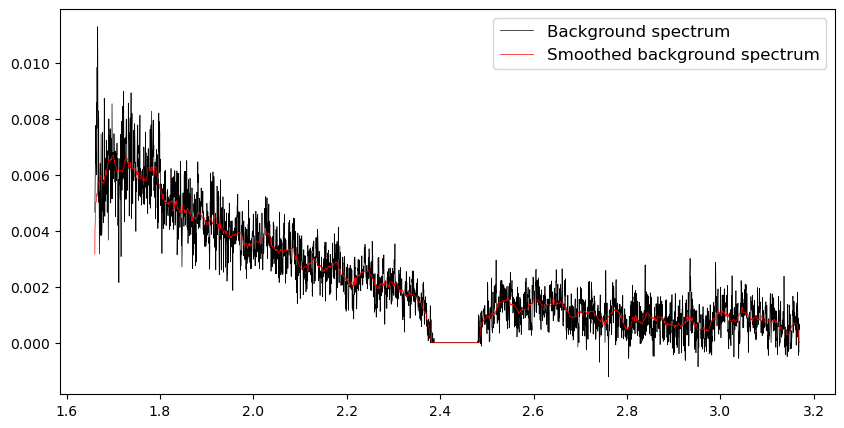

In [52]:
Background_spec = pyfits.getdata('/Users/jansen/work/Torun_school/Background_spec.fits')
Background_spec *= 1e4 * 1e15  # dont forget to normalize it like you did with the flux cube

f,ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(obs_wave, Background_spec, color='k', lw=0.5, label='Background spectrum')


from scipy.signal import medfilt


Background_smoothed = medfilt(np.array(Background_spec, dtype=float), 51)

ax.plot(obs_wave, Background_smoothed, color='r', lw=0.5, label='Smoothed background spectrum')

ax.legend(loc='upper right', fontsize=12)

plt.show()

we can now subtract the smoothed background from every spaxel in the Cube, and extract the 1D spectrum like we did before. 

In [53]:
# Subtracting things from every pixel.
Flux_cube -= Background_smoothed[:,np.newaxis,np.newaxis]


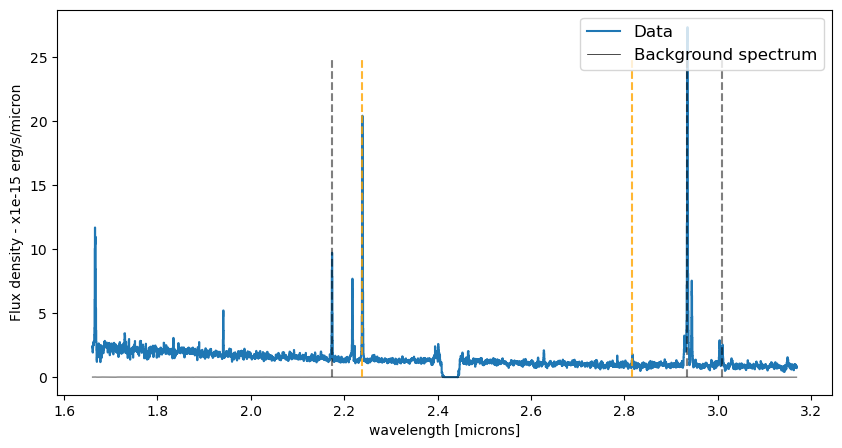

In [54]:

def sp_circ_ap(cenx,ceny,rad,Flux_cube):

    nwl = len(Flux_cube[:,0,0])
    nx = len(Flux_cube[0,0,:])
    ny = len(Flux_cube[0,:,0])
    # creates array with one spectrum per row
    intermarray = np.full((nwl,nx*ny), np.nan)
    # fills it with nans
    
    nloop = 0
    # loop on data
    for x in range(nx) :
        for y in range(ny) :  
            distance = np.sqrt((x-cenx)**2+(y-ceny)**2)
            if distance < rad :
                intermarray[:,int(nloop)] = Flux_cube[:,int(y),int(x)]
                nloop += 1
               
    # average
    outspec = np.nansum(intermarray,axis=1)
    return outspec

D1_spec = sp_circ_ap(44,47,5,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid', label='Data')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.plot(obs_wave, Background_spec, color='k', lw=0.5, label='Background spectrum')


ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

#ax.set_xlim(2.15,2.25)

ax.legend(loc='upper right', fontsize=12)
plt.show()